In [1]:
# import dill
import numpy as np
from matplotlib import figure, gridspec
# from pathlib import Path
# from astropy.table import Table
# from astropy import units as u
# from astropy.coordinates import SkyCoord

import scanner_interpretation as scani

import healpy as hp
import pandas as pd

from matplotlib import colors,cm
import matplotlib.pyplot as plt
from astropy import visualization as vis



bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
versions = ["hess1","hess1u"]
paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# mplets = scani.Multiplets(paths[0])
# mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
mplet_list = [scani.Multiplets(path) for path in paths]


unicorns = [9,18]
for j in unicorns:
    mplet_list[j].objectifyColumns()

    
mplets = mplet_list[0]
mplets.appendMultiplets(*mplet_list[1:])

Aitov scatter

In [ ]:
fig,ax = mplets.getAitoffFigure()
fig.savefig("figures/combined/aitoff.png",facecolor="white",dpi=300)

Cornerplot of the resulting multiplets

In [ ]:
# plotting mplet results
from corner import corner

fig = corner(mplets.table.to_pandas(),var_names=["Nmax","dt","da"])
fig.savefig("figures/combined/corner_center.png",facecolor="white",dpi=300)

HEALPix

In [ ]:
mask = mplets.table["Nmax"]>=3
cmap = cm.plasma
cmap.set_under("white")
m = scani.cat2hpx(mplets.table[mask]["MEDIAN_RA"],mplets.table[mask]["MEDIAN_DEC"],nside=2**7)
hp.mollview(m,cmap=cmap)
ax = plt.gca()
ax.images[0].set_norm(colors.PowerNorm(.2))
# plt.savefig("figures/combined/healpy.png",facecolor="white")

In [2]:
from tevcat import TeVCat
tevcat = TeVCat()
sourcenames,distances,indices = mplets.searchTeVCat(tevcat.sources)

Unknown observatory name found in GRB 160821B:  None
Unknown "discoverer" ID found in GRB 160821B: None
Unknown observatory name found in SNR G004.8+6.2:  None
Unknown "discoverer" ID found in SNR G004.8+6.2: None
Unknown observatory name found in 3HWC J0621+382:  None
Unknown "discoverer" ID found in 3HWC J0621+382: None
Unknown observatory name found in 3HWC J0630+186:  None
Unknown "discoverer" ID found in 3HWC J0630+186: None
Unknown observatory name found in 3HWC J0631+107:  None
Unknown "discoverer" ID found in 3HWC J0631+107: None


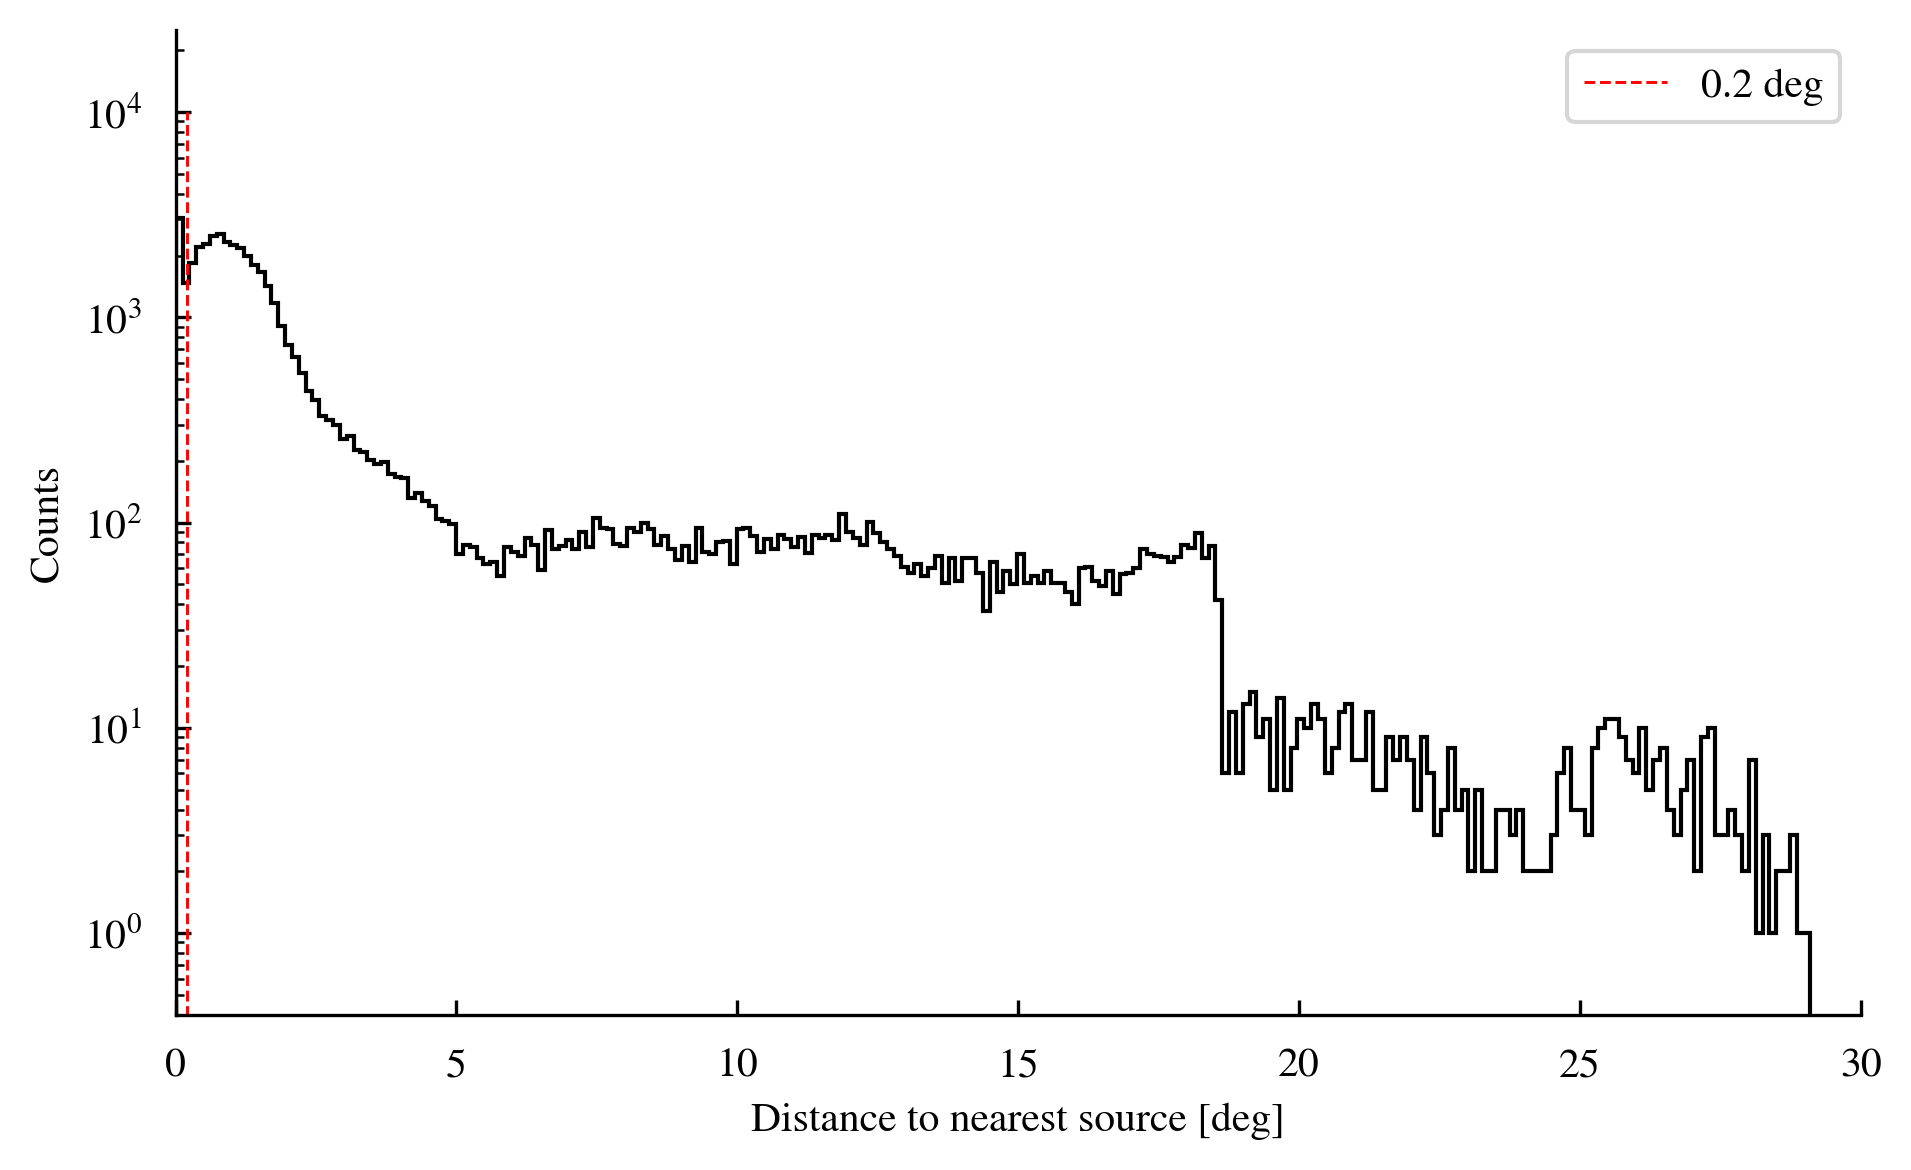

In [16]:
vline_sourcebound = .2
hist = vis.hist(mplets.table["DISTANCES_DEG"],bins="freedman",histtype="step")
ax = plt.gca()
ax.set_xlabel("Distance to nearest source [deg]")
ax.set_ylabel("Counts")
ax.vlines(vline_sourcebound,0,1e4,color="red",ls="--",label=f"{vline_sourcebound} deg")
ax.set_yscale("log")
ax.set_xlim(0,30)
ax.legend()
# ax.set_xscale("log")
plt.savefig("figures/combined/sourcedist_hist.png",facecolor="white")

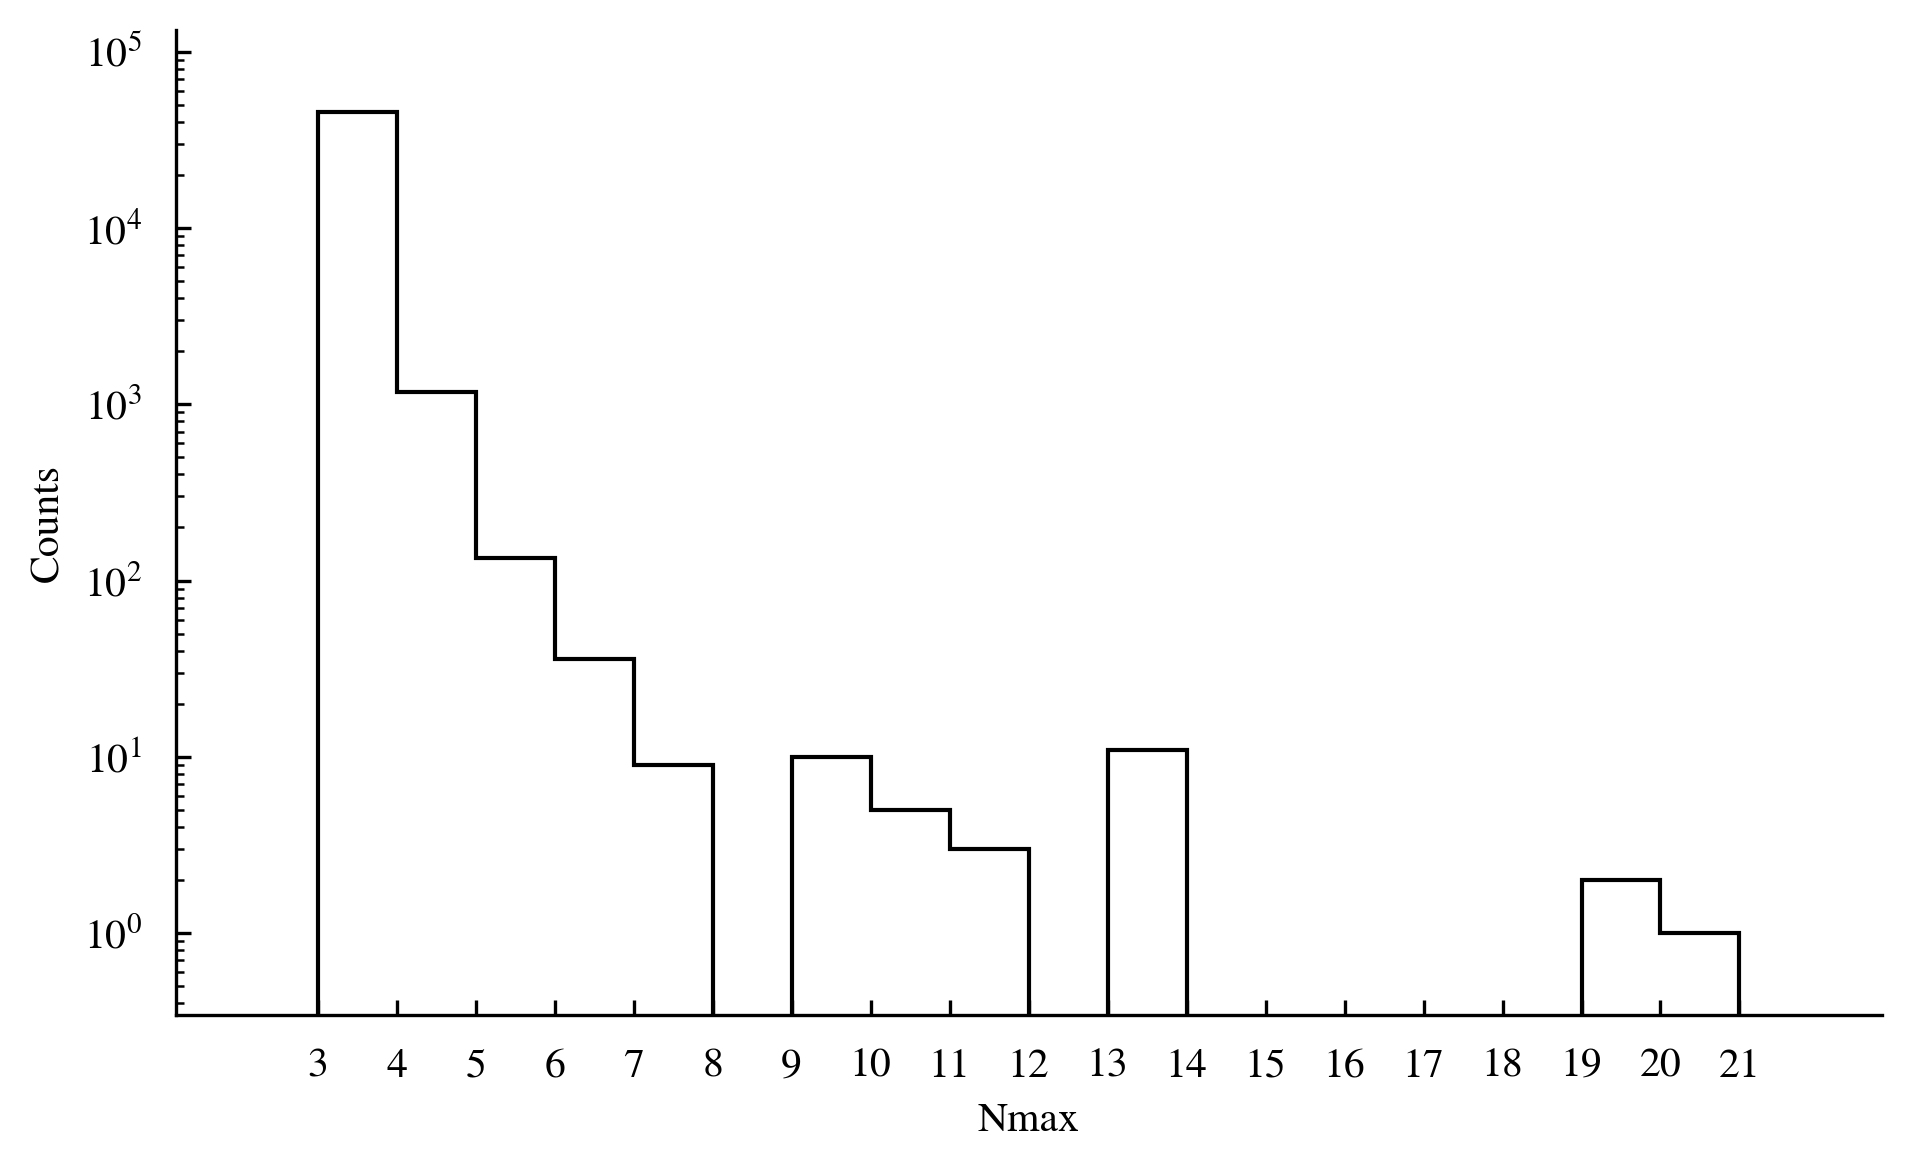

In [15]:
hist = vis.hist(mplets.table["Nmax"],bins=range(3,22),histtype="step")
ax = plt.gca()
ax.set_xlabel("Nmax")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.set_xticks(range(3,22))
plt.savefig("figures/combined/Nmax_hist.png",facecolor="white")

In [6]:
big_mplets = mplets.table["Nmax"] >= 7
mplets.table.group_by("SOURCE")
mplets.table[big_mplets]

Nmax,OBS_ID,ID,RA,DEC,TIME,ENERGY,dt,da,MEDIAN_RA,MEDIAN_DEC,SkyCoord.ra,SkyCoord.dec,MEDIAN_GLAT,MEDIAN_GLON,SOURCE,DISTANCES_DEG
int64,uint32,object,object,object,object,object,float64,float64,float32,float32,float32,float32,float64,float64,object,float64
7,33819,[18433999635164 18433999635191 18438294601736 18438294602017\n 18438294602098 18438294602148 18438294602161],[329.7734 329.71216 329.78818 329.72278 329.71613 329.7289 329.7987 ],[-30.270956 -30.233942 -30.222689 -30.21218 -30.222622 -30.271189\n -30.239662],['2006-07-31T02:15:57.023530060' '2006-07-31T02:15:57.156182105'\n '2006-07-31T02:15:57.566153342' '2006-07-31T02:15:58.865111643'\n '2006-07-31T02:15:59.325859601' '2006-07-31T02:15:59.591472441'\n '2006-07-31T02:15:59.667671019'],[0.22665536 0.52116966 0.4225304 0.8789087 0.31284556 0.2429501\n 0.2866357 ],2644141056.0,0.08673678146680984,329.7289,-30.233942,329.7289,-30.233942,-52.25705060702528,17.71878463447941,Canonical Name:\tPKS 2155-304\nTeVCat Name:\tTeV J2158-302\nOther Names:\tHESS J2158-302\nSource Type:\tHBL\nRA:\t21h58m52.7s (hh mm ss)\nDec:\t-30d13m18s (dd mm ss)\nGal Long:\t17.74 (deg)\nGal Lat:\t-52.25 (deg)\nDistance:\tz = 0.116000\nFlux:\t0.150 (Crab Units)\nEnergy Threshold:\t300 (GeV)\nSize (X):\t0.00 (deg)\nSize (Y):\t0.00 (deg)\nDiscovery Date:\t1999-06\nDiscovered by:\tDurham,0.015416675575300937
7,33816,[14169097109846 14169097109850 14169097109912 14169097110096\n 14169097110108 14169097110163 14169097110214],[329.721 329.67142 329.76782 329.74948 329.73492 329.7274 329.6216 ],[-30.201393 -30.183062 -30.2564 -30.288694 -30.303522 -30.265446\n -30.149069],['2006-07-31T00:57:01.045750910' '2006-07-31T00:57:01.052913005'\n '2006-07-31T00:57:01.364115531' '2006-07-31T00:57:02.359331423'\n '2006-07-31T00:57:02.419745738' '2006-07-31T00:57:02.686724717'\n '2006-07-31T00:57:02.949886376'],[0.28040028 0.4031716 0.3454885 0.2435056 0.2067934 0.32486728\n 0.45588985],1904135680.0,0.1915603602766528,329.7274,-30.2564,329.7274,-30.2564,-52.2581860949502,17.68207919177645,Canonical Name:\tPKS 2155-304\nTeVCat Name:\tTeV J2158-302\nOther Names:\tHESS J2158-302\nSource Type:\tHBL\nRA:\t21h58m52.7s (hh mm ss)\nDec:\t-30d13m18s (dd mm ss)\nGal Long:\t17.74 (deg)\nGal Lat:\t-52.25 (deg)\nDistance:\tz = 0.116000\nFlux:\t0.150 (Crab Units)\nEnergy Threshold:\t300 (GeV)\nSize (X):\t0.00 (deg)\nSize (Y):\t0.00 (deg)\nDiscovery Date:\t1999-06\nDiscovered by:\tDurham,0.03559433928315408
7,33821,[20688857465489 20688857465511 20693152432191 20693152432197\n 20693152432228 20693152432426 20693152432433],[329.72617 329.7698 329.75177 329.78217 329.7002 329.6542 329.68497],[-30.210537 -30.266855 -30.300657 -30.135752 -30.239717 -30.198156\n -30.249628],['2006-07-31T02:55:47.390225464' '2006-07-31T02:55:47.519630248'\n '2006-07-31T02:55:48.029125744' '2006-07-31T02:55:48.046659285'\n '2006-07-31T02:55:48.253960425' '2006-07-31T02:55:49.349513108'\n '2006-07-31T02:55:49.412788207'],[0.4442363 0.48685768 0.46036494 0.2588837 0.3571928 0.52190596\n 0.31335908],2022562816.0,0.1759070158344138,329.72617,-30.239717,329.72617,-30.239717,-52.25531182203754,17.708981497331425,Canonical Name:\tPKS 2155-304\nTeVCat Name:\tTeV J2158-302\nOther Names:\tHESS J2158-302\nSource Type:\tHBL\nRA:\t21h58m52.7s (hh mm ss)\nDec:\t-30d13m18s (dd mm ss)\nGal Long:\t17.74 (deg)\nGal Lat:\t-52.25 (deg)\nDistance:\tz = 0.116000\nFlux:\t0.150 (Crab Units)\nEnergy Threshold:\t300 (GeV)\nSize (X):\t0.00 (deg)\nSize (Y):\t0.00 (deg)\nDiscovery Date:\t1999-06\nDiscovered by:\tDurham,0.01921036184737426
7,33813,[7653631722584 7653631722812 7653631722950 7653631723036 7653631723080\n 7653631723116 7653631723185],[329.7202 329.74002 329.7566 329.82483 329.705 329.7608 329.75403],[-30.189991 -30.224613 -30.283806 -30.195103 -30.169071 -30.203876\n -30.28498 ],['2006-07-30T23:08:33.900290782' '2006-07-30T23:08:34.972166115'\n '2006-07-30T23:08:35.525961215' '2006-07-30T23:08:36.015279824'\n '2006-07-30T23:08:36.238439137' '2006-07-30T23:08:36.4252422

In [ ]:
mplets.table["SOURCE"][1].getID()